# Secure Data Disclosure: Client side

This notebook showcases how researcher could use the Secure Data Disclosure system. It explains the different functionnalities provided by the `fso-sdd-demo` client library to interact with the secure server.

The secure data are never visible by researchers. They can only access to differentially private responses via queries to the server.

Each user has access to one or multiple projects and for each dataset has a limited budget $\epsilon$, $\delta$.

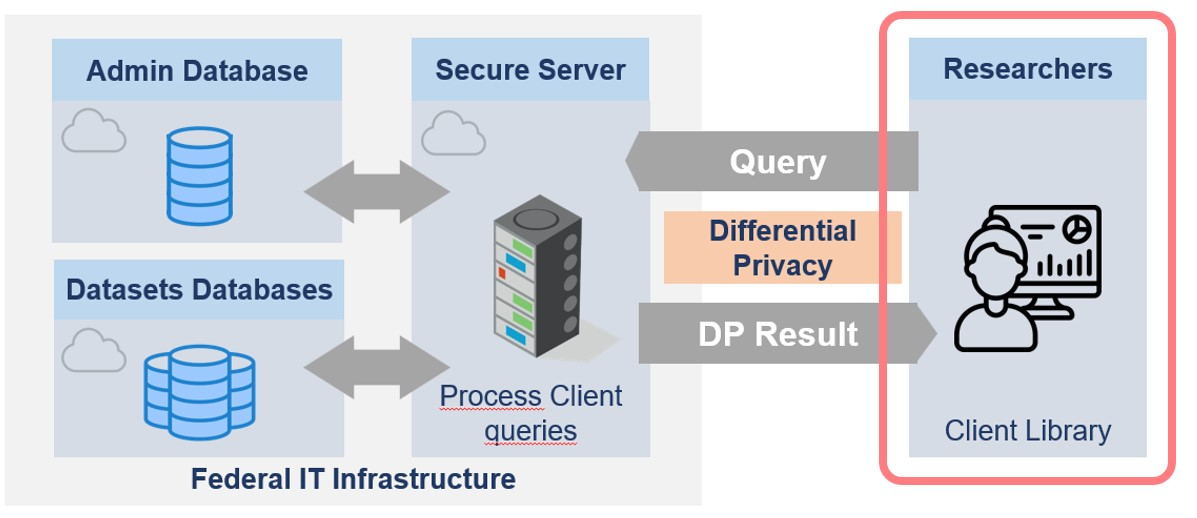

In [29]:
from IPython.display import Image
Image(filename="images/image_client.jpg", width=800)

🐧🐧🐧
In this notebook the researcher is a penguin researcher named Dr. Antarctica. She aims to do a grounbdbreaking research on various penguins dimensions.

Therefore, the powerful queen Icerbegina 👑 had the data collected. But in order to get the penguins to agree to participate she promised them that no one would be able to look at the data and that no one would be able to guess the bill width of any specific penguin (which is very sensitive information) from the data. Nobody! Not even the researchers. The queen hence stored the data on the Secure Data Disclosure Server and only gave a small budget to Dr. Antarctica.

This is not a problem for Dr. Antarctica as she does not need to see the data to make statistics thanks to the Secure Data Disclosure Client library `fso-sdd-demo`. 
🐧🐧🐧

## Step 1: Install the library
To interact with the secure server on which the data is stored, Dr.Antartica first needs to install the library `fso-sdd-demo` on her local developping environment. 

It can be installed via the pip command:

In [30]:
#!pip install fso-sdd-demo

In [31]:
from fso_sdd_demo.client import Client
import numpy as np

## Step 2: Initialise the client

Once the library is installed, a Client object must be created. It is responsible for sending sending requests to the server and processing responses in the local environment. It enables a seamless interaction with the server. 

To create the client, Dr. Antartica needs to give it a few parameters:
- a url: the root application endpoint to the remote secure server.
- user_name: her name as registered in the database (Dr. Alice Antartica)
- dataset_name: the name of the dataset that she wants to query (PENGUIN)

She will only be able to query on the real dataset if the queen Icergina has previously made her an account in the database, given her access to the PENGUIN dataset and has given her some epsilon and delta credit. (As is done in the Secure Data Disclosure Notebook: Server side).

In [32]:
APP_URL = "http://sdd_server_dev:80" # Onyxia: "https://sdd-server-demo.lab.sspcloud.fr"
USER_NAME = "Dr. Antartica"
DATASET_NAME = "PENGUIN"
client = Client(url=APP_URL, user_name = USER_NAME, dataset_name = DATASET_NAME)

And that's it for the preparation. She is now ready to use the various functionnalities offered by `fso_sdd_demo`.

## Step 3: Understand the functionnalities of the library

### Getting dataset metadata

Dr. Antartica has never seen the data and as a first step to understand what is available to her, she would like to check the metadata of the dataset. Therefore, she just needs to call the `get_dataset_metadata()` function of the client. As this is public information, this does not cost any budget.

This function returns metadata information in the same format as [SmartnoiseSQL dictionary format](https://docs.smartnoise.org/sql/metadata.html#dictionary-format), where among other, there is information about all the available columns, their type, bound values (see Smartnoise page for more details).

In [33]:
penguin_metadata = client.get_dataset_metadata()['']['Schema']['Table']
penguin_metadata

{'max_ids': 1,
 'row_privacy': True,
 'species': {'type': 'string'},
 'island': {'type': 'string'},
 'bill_length_mm': {'type': 'float', 'lower': 30.0, 'upper': 65.0},
 'bill_depth_mm': {'type': 'float', 'lower': 13.0, 'upper': 23.0},
 'flipper_length_mm': {'type': 'float', 'lower': 150.0, 'upper': 250.0},
 'body_mass_g': {'type': 'float', 'lower': 2000.0, 'upper': 7000.0},
 'sex': {'type': 'string'}}

Based on this Dr. Antartica knows that there are 7 columns, 3 of string type (species, island, sex) and 4 of float type (bill length, bill depth, flipper length and body mass) with their associated bounds. She also knows based on the field `max_ids: 1` that each penguin can only be once in the dataset and on the field `row_privacy: True` that each row represents a single penguin. 

### Get a dummy dataset

Now, that she has seen and understood the metadata, she wants to get an even better understanding of the dataset (but is still not able to see it). A solution to have an idea of what the dataset looks like it to create a dummy dataset. 

Based on the public metadata of the dataset, a random dataframe can be created created. By default, there will be 100 rows and the seed is set to 42 to ensure reproducibility, but these 2 variables can be changed to obtain different dummy datasets.
Getting a dummy dataset does not affect the budget as there is no differential privacy here, it is not a synthetic dataset and all that could be learn here is already present in the public metadata.

Dr. Antartica first create a dummy dataset with 200 rows and chooses a seed of 0.

In [34]:
NB_ROWS = 200
SEED = 0

In [35]:
df_dummy = client.get_dummy_dataset(
    nb_rows = NB_ROWS, 
    seed = SEED
)

print(df_dummy.shape)
df_dummy.head()

(200, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,d,b,49.208473,16.117959,190.125950,2873.291927,d
1,d,b,55.031628,19.963435,242.929142,3639.940005,c
2,b,a,51.096718,16.777518,159.961493,5401.743330,a
3,b,c,49.070911,14.796037,244.530153,2316.038092,a
4,c,b,44.827918,13.246787,236.948853,5036.246870,c


### Query on dummy dataset
Now that she has an idea of what the data looks like, she wants to start querying the real dataset to for her research. However, before this other tools are at her disposal to reduce potential error risks and avoid spending budget on irrelevant queries. Of course, this does not have any impact on the budget.

It is possible to specify the flag `dummy=True` in the various queries to perform the query on the dummy dataset instead of the real dataset and ensure that the queries are doing what is expected of them. 

Therefore Dr. Antartica computes the results that she gets on the dummy dataframe that she created locally and on the same dummy dataframe in the server via a query and compare them to ensure that the query is well defined and works within the server.

She tests with an example on average bill length of the dataframe.

#### Average and number of rows with smartnoise-sql library on remote dummy

In [41]:
# Average bill length in mm
QUERY = "SELECT COUNT(*) AS nb_penguins, \
        AVG(bill_length_mm) AS avg_bill_length_mm \
        FROM Schema.Table"

In [44]:
# On the remote server dummy dataframe
dummy_res = client.smartnoise_query(
    query = QUERY,  
    epsilon = 100.0, # make sure to select high values of epsilon and delta to have small differences
    delta = 2.0,     # make sure to select high values of epsilon and delta to have small differences
    dummy = True, 
    nb_rows = NB_ROWS,
    seed = SEED
)

In [45]:
print(f"Average bill length in remote dummy: {np.round(dummy_res['query_response']['avg_bill_length_mm'][0], 2)}mm.")
print(f"Number of rows in remote dummy: {np.round(dummy_res['query_response']['nb_penguins'][0], 2)}.")

Average bill length in remote dummy: 47.52mm.
Number of rows in remote dummy: 200.


### Get current budget

It is the first time that Dr. Antartica connects to the server and she wants to know how much buget the queen assigned her.
Therefore, she calls the fonction `get_initial_budget`.

In [46]:
client.get_initial_budget()

{'initial_epsilon': 45, 'initial_delta': 0.005}

She sees that she has 10.0 epsilon and 0.005 epsilon at her disposal.

Then she checks her total spent budget `get_total_spent_budget`. As she only did queries on metadata on dummy dataframes, this should still be 0.

In [47]:
client.get_total_spent_budget()

{'total_spent_epsilon': 0, 'total_spent_delta': 0}

It will also be useful to know what the remaining budget is. Therefore, she calls the function `get_remaining_budget`. It just substarcts the total spent budget from the initial budget.

In [48]:
client.get_remaining_budget()

{'remaining_epsilon': 45, 'remaining_delta': 0.005}

As expected, for now the remaining budget is equal to the inital budget.

### Estimate cost of a query
Another safeguard is the functionnality to estimate the cost of a query. As in OpenDP and SmartnoiseSQL, the budget that will by used by a query might be slightly different than what is asked by the user. The `estimate cost` function returns the estimated real cost of any query.

Again, of course, this will not impact the user's budget.

Dr. Antartica checks the budget that computing the average bill length will really cost her if she asks the query with an `epsilon` and a `delta`.

In [49]:
EPSILON = 0.5
DELTA = 1e-4

In [50]:
client.estimate_smartnoise_cost(
    query = QUERY, 
    epsilon = EPSILON, 
    delta = DELTA
)

{'epsilon_cost': 1.5, 'delta_cost': 0.00014999500000001387}

This query would actually cost her 1.5 epsilon and delta 1.4999e-4. She decides that it is good enough.

### Query on real private dataset with smartnoise-sql
Now that all the safeguard functions were tested, Dr. Antartica is ready to query on the real dataset and get a differentially private response of the bumber of penguins and average bill length. By default, the flag `dummy` is False so setting it is optional. She uses the values of `epsilon` and `delta` that she selected just before.

Careful: This command DOES spend the budget of the user and the remaining budget is updated for every query.

In [51]:
client.get_remaining_budget()

{'remaining_epsilon': 45, 'remaining_delta': 0.005}

In [52]:
response = client.smartnoise_query(
    query = QUERY,  
    epsilon = EPSILON, 
    delta = DELTA,
    dummy = False # Optionnal
)

In [53]:
nb_penguins = response['query_response']['nb_penguins'].iloc[0]
print(f"Number of penguins in real data: {nb_penguins}.")

avg_bill_length = np.round(response['query_response']['avg_bill_length_mm'].iloc[0], 2)
print(f"Average bill length of penguins in real data: {avg_bill_length}mm.")

Number of penguins in real data: 347.
Average bill length of penguins in real data: 43.63mm.


After each query on the real dataset, the budget informations are also returned to the researcher. It is possible possible to check the remaining budget again afterwards:

In [54]:
client.get_remaining_budget()

{'remaining_epsilon': 43.5, 'remaining_delta': 0.004850004999999986}

As can be seen in `get_total_spent_budget()`, it is the budget estimated with `estimate_smartnoise_cost()` that was spent.

In [55]:
client.get_total_spent_budget()

{'total_spent_epsilon': 1.5, 'total_spent_delta': 0.00014999500000001387}

Dr. Antartica has now a differentially private estimation of the number of penguins in the dataset and is confident to use the library for the rest of her analyses.

## Step 4: Penguin statistics with opendp

In [56]:
import opendp_polars.prelude as dp
import opendp_polars.transformations as trans
import opendp_polars.measurements as meas

dp.enable_features("contrib")

### Confidence intervals for bill length over the whole population

She is first interested to have a better idea of the distribution of bill length of all species. She already has the count and average from the previous step, so she only needs the variance values.

She first checks the metadata again to use the relevant values in the pipeline.

In [57]:
penguin_metadata

{'max_ids': 1,
 'row_privacy': True,
 'species': {'type': 'string'},
 'island': {'type': 'string'},
 'bill_length_mm': {'type': 'float', 'lower': 30.0, 'upper': 65.0},
 'bill_depth_mm': {'type': 'float', 'lower': 13.0, 'upper': 23.0},
 'flipper_length_mm': {'type': 'float', 'lower': 150.0, 'upper': 250.0},
 'body_mass_g': {'type': 'float', 'lower': 2000.0, 'upper': 7000.0},
 'sex': {'type': 'string'}}

She can define the columns names and the bounds of the relevant column.

In [58]:
columns = ["species", "island", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "sex"]

In [59]:
bill_length_min = penguin_metadata['bill_length_mm']['lower']
bill_length_max = penguin_metadata['bill_length_mm']['upper']
bill_length_min, bill_length_max

(30.0, 65.0)

She can now define the pipeline of the transformation to have the variance that she wants on the data:

In [60]:
bill_length_transformation_pipeline = (
    trans.make_split_dataframe(separator=",", col_names=columns) >>
    trans.make_select_column(key="bill_length_mm", TOA=str) >>
    trans.then_cast_default(TOA=float) >>
    trans.then_clamp(bounds=(bill_length_min, bill_length_max)) >>
    trans.then_resize(size=nb_penguins.tolist(), constant=avg_bill_length) >>
    trans.then_variance()
)

However, when she tries to execute it on the server, she has an error (see below). 

In [61]:
# Expect to fail !!!
client.opendp_query(
    opendp_pipeline = bill_length_transformation_pipeline,
    dummy=True
)

Error while processing OpenDP request in server                     status code: 400 message: {"detail":"The pipeline provided is not a measurement.                 It cannot be processed in this server."}


'{"detail":"The pipeline provided is not a measurement.                 It cannot be processed in this server."}'

This is because the server will only allow measurement pipeline with differentially private results. She adds Laplacian noise to the pipeline and should be able to instantiate the pipeline.

In [62]:
var_bill_length_measurement_pipeline = (
    bill_length_transformation_pipeline >>
    meas.then_laplace(scale=5.0)
)

Now that there is a measurement, she is able to apply the pipeline on the dummy dataset of the server.

In [63]:
dummy_var_res = client.opendp_query(
    opendp_pipeline = var_bill_length_measurement_pipeline, 
    dummy=True
)
print(f"Dummy result for variance: {np.round(dummy_var_res['query_response'], 2)}")

Dummy result for variance: 35.51


With opendp, the function `estimate_opendp_cost` is particularly useful to estimate the used `epsilon` and `delta` based on the `scale` value.

In [64]:
cost_res = client.estimate_opendp_cost(
    opendp_pipeline = var_bill_length_measurement_pipeline
)
cost_res

Error while executing provided query in server:
status code: 422 message: {"detail":[{"loc":["body","input_data_type"],"msg":"field required","type":"value_error.missing"}]}


'{"detail":[{"loc":["body","input_data_type"],"msg":"field required","type":"value_error.missing"}]}'

She can now execute the query on the real dataset.

In [30]:
var_res = client.opendp_query(
    opendp_pipeline = var_bill_length_measurement_pipeline, 
)

In [31]:
print(f"Number of penguins: {nb_penguins} (from previous smartnoise-sql query).")

print(f"Average bill length: {np.round(avg_bill_length, 2)} (from previous smartnoise-sql query).")

var_bill_length = var_res['query_response']
print(f"Variance of bill length: {np.round(var_bill_length, 3)} (from opendp query).")

Number of penguins: 343 (from previous smartnoise-sql query).
Average bill length: 44.13 (from previous smartnoise-sql query).
Variance of bill length: 1.575 (from opendp query).


She can now do all the postprocessing that she wants with the returned data without adding any privacy risk. 

In [32]:
# Get standard error
standard_error = np.sqrt(var_bill_length/nb_penguins)
print(f"Standard error of bill length: {np.round(standard_error, 2)}.")

Standard error of bill length: 0.07.


In [33]:
 # Compute the 95% confidence interval
ZSCORE = 1.96
lower_bound = np.round(avg_bill_length - ZSCORE*standard_error, 2)
upper_bound = np.round(avg_bill_length + ZSCORE*standard_error, 2)
print(f"The 95% confidence interval of the bill length of all penguins is [{lower_bound}, {upper_bound}].")

The 95% confidence interval of the bill length of all penguins is [44.0, 44.26].


# FSO Example: (Synthetic) Income dataset

## Boxplot of income per partitions of the population

### Disclaimer: Temporary Version of OpenDP with Polars

In [34]:
# Import library
import numpy as np
import pandas as pd
import polars as pl
import opendp_polars.prelude as dp

dp.enable_features("contrib")

### Data preparation

#### Column types and bounds

In [35]:
# Income bounds
income_lower_bound, income_upper_bound = 1_000.0, 100_000.0

In [36]:
# Define dtype domain with bounds
lf_domain = dp.lazyframe_domain([
    dp.series_domain("region", dp.atom_domain(T=int)),
    dp.series_domain("eco_branch", dp.atom_domain(T=int)),
    dp.series_domain("profession", dp.atom_domain(T=int)),
    dp.series_domain("education", dp.atom_domain(T=int)),
    dp.series_domain("age", dp.atom_domain(T=int)),
    dp.series_domain("sex", dp.atom_domain(T=int)),
    dp.series_domain("income", dp.atom_domain(
        T=float,
        bounds=(income_lower_bound, income_upper_bound)
    ))
])

#### Counts per partition of the population

In [37]:
# Total
total_counts = pl.LazyFrame({
    "counts": [2_032_543]
}, schema_overrides={"counts": pl.UInt32})

# For sex
sex_counts = pl.LazyFrame({
    "sex": [0, 1], 
    "counts": [634_720, 1_397_823]
}, schema_overrides={"sex": pl.Int32, "counts": pl.UInt32})

# For region
region_counts = pl.LazyFrame({
    "region": [1, 2, 3, 4, 5, 6, 7],
    "counts": [352_001, 474_690, 267_304, 366_879, 284_638, 210_800, 76_231]
}, schema_overrides={"region": pl.Int32, "counts": pl.UInt32})

# For region and sex
sex_region_counts = pl.LazyFrame({
    "sex": [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 
    "region": [1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7], 
    "counts": [113_367, 148_265, 83_326, 113_715, 87_668, 64_357, 24_022, 238_634, 326_425, 183_978, 253_164, 196_970, 146_443, 52_209]
}, schema_overrides={"sex": pl.Int32, "region": pl.Int32, "counts": pl.UInt32})

# Add counts to margin
lf_domain = lf_domain.with_counts(
    total_counts
).with_counts(sex_counts).with_counts(region_counts).with_counts(sex_region_counts)

### Income distribution for partitions of the population:
#### Prepare the pipeline

In [38]:
# Prepare a list of candidates
candidates = [x * 250.0 for x in range(8, 52)]
print(candidates)

[2000.0, 2250.0, 2500.0, 2750.0, 3000.0, 3250.0, 3500.0, 3750.0, 4000.0, 4250.0, 4500.0, 4750.0, 5000.0, 5250.0, 5500.0, 5750.0, 6000.0, 6250.0, 6500.0, 6750.0, 7000.0, 7250.0, 7500.0, 7750.0, 8000.0, 8250.0, 8500.0, 8750.0, 9000.0, 9250.0, 9500.0, 9750.0, 10000.0, 10250.0, 10500.0, 10750.0, 11000.0, 11250.0, 11500.0, 11750.0, 12000.0, 12250.0, 12500.0, 12750.0]


In [39]:
# Partitions
PARTITIONS = ['sex', 'region']

In [40]:
metric = dp.symmetric_distance()                                     # Input metric
expr_domain = dp.expr_domain(lf_domain, grouping_columns=PARTITIONS) # Expr domain (Groupby)
temperature = 1.0                                                    # Noise parameter

In [41]:
def make_quantile_pipeline(quantile):
    # Create expression
    return (
        (dp.csv_domain(lf_domain), metric)
        >> dp.t.then_scan_csv()
        >> dp.t.then_groupby_stable(PARTITIONS)
        >> dp.m.then_private_agg(
            dp.c.make_basic_composition(
                [
                    (expr_domain, dp.l1(metric))
                    >> dp.t.then_col('income')
                    >> dp.m.then_private_quantile_expr(candidates, temperature, quantile)
                ]
            )
        )
        >> dp.t.make_collect(lf_domain, metric)
    )

In [42]:
q25 = make_quantile_pipeline(0.25)
q50 = make_quantile_pipeline(0.5)
q75 = make_quantile_pipeline(0.75)

#### Apply pipeline on data

In [44]:
INCOME_DATA = 'income_synthetic_data.csv'
r25 = q25(INCOME_DATA).to_pandas()
r50 = q50(INCOME_DATA).to_pandas()
r75 = q75(INCOME_DATA).to_pandas()

In [45]:
results = pd.merge(r25, r50, on=PARTITIONS, suffixes=('_25', '_50'))
results = pd.merge(results, r75, on=PARTITIONS)
results.sort_values(by = ['region', 'sex']).head()

,sex,region,income_25,income_50,income
3,0,1,[5000.0],[6250.0],[7750.0]
10,1,1,[5750.0],[7000.0],[8750.0]
1,0,2,[4750.0],[6000.0],[7250.0]
8,1,2,[5500.0],[7000.0],[8500.0]
5,0,3,[5000.0],[6250.0],[7750.0]


#### Visualise results

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
def quantile_data(q1, q2, q3):
    return np.concatenate((np.random.uniform(q1[0], q2[0], size=50), np.random.uniform(q2[0], q3[0], size=50)))

results['data'] = results.apply(
    lambda row: quantile_data(row["income_25"], row["income_50"], row["income"]),
    axis=1,
)
results['sex'] = results['sex'].replace({0: 'woman', 1: 'man'})
results['region'] = results['region'].replace({1: 'Lemanique', 2: 'Mittleland', 3: 'North-West', 4: 'Zürich', 5: 'Oriental', 6: 'Central', 7: 'Ticino'})
results = results.explode('data', ignore_index=True)

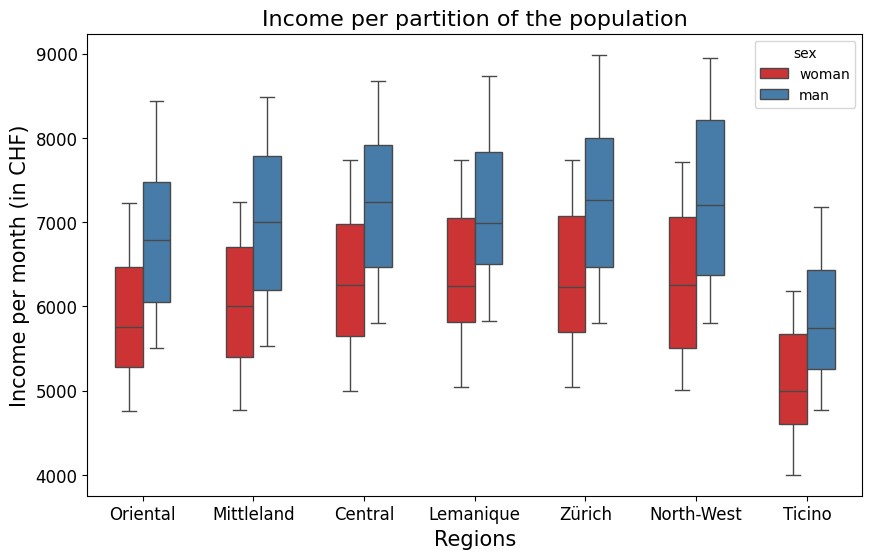

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="region", y="data", hue="sex", data=results, palette="Set1", width=0.5);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Regions', fontsize=15)
plt.ylabel('Income per month (in CHF)', fontsize=15)
plt.title('Income per partition of the population', fontsize=16)
plt.show()